In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
BATCH_SIZE = 64
LATENT_DIM = 100
LEARNING_RATE = 0.0002
BETA1 = 0.5
EPOCHS = 100
GAMMA = 0.99  # Discount factor for RL

Found 63565 files belonging to 1 classes.


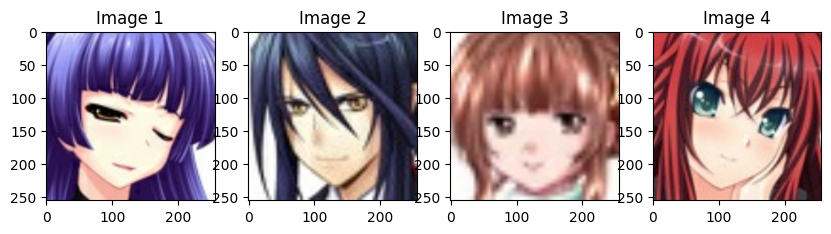

In [3]:
import keras
import matplotlib.pyplot as plt

img_width, img_height = 256, 256
batchsize = 32

# Load the dataset using image_dataset_from_directory
train = keras.utils.image_dataset_from_directory(
    directory='datasets/animefacedataset',
    batch_size=batchsize,
    image_size=(img_width, img_height))

# Visualizing a Batch of Anime Face Images
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))

# Display a few images in the batch
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))  # Convert to int for proper display
    ax[idx].title.set_text(f'Image {idx+1}')
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory where the dataset is stored
DIR = 'datasets/animefacedataset'

# Create an ImageDataGenerator object for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

# Create the training generator
train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size=(64, 64),  # Resize the images to 64x64
        batch_size=batchsize,
        class_mode=None)  # Since you have only one class, we can ignore class labels

Found 63565 images belonging to 1 classes.


In [12]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class AnimeFaceDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        
        # Check the directory structure
        image_folder = os.path.join(dataset_dir, 'images')  # Make sure there's an 'images' folder
        if not os.path.exists(image_folder):
            raise FileNotFoundError(f"Expected 'images' folder in the directory {dataset_dir}")

        valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        # List all image files in the 'images' folder
        self.image_files = [f for f in os.listdir(image_folder) 
                            if os.path.isfile(os.path.join(image_folder, f)) 
                            and any(f.lower().endswith(ext) for ext in valid_extensions)]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_folder = os.path.join(self.dataset_dir, 'images')  # Ensure images are in the 'images' subfolder
        img_name = os.path.join(image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')  # Open image and convert to RGB (3 channels)
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        return image


In [13]:
dataset_dir = 'datasets/animefacedataset'
anime_dataset = AnimeFaceDataset(dataset_dir=dataset_dir, transform=transform)

# Verify the dataset
print(f"Number of samples in dataset: {len(anime_dataset)}")
# Print a few sample image filenames
print(f"Sample image filenames: {anime_dataset.image_files[:5]}")


Number of samples in dataset: 63565
Sample image filenames: ['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg']


torch.Size([32, 3, 64, 64])


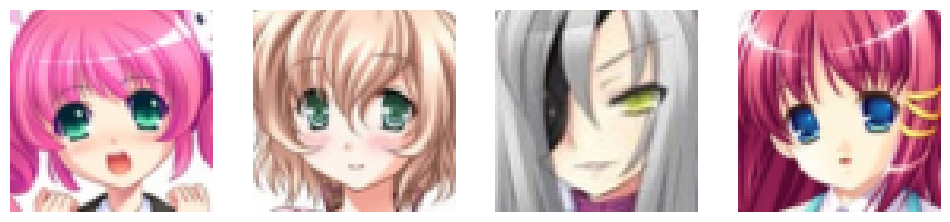

In [14]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32  # You can adjust this based on your memory and system

# Create DataLoader for batching
data_loader = DataLoader(anime_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check if DataLoader is working fine
data_iter = iter(data_loader)
images = next(data_iter)  # Get the next batch of images
print(images.shape)  # Should print (batch_size, 3, 64, 64)

# Visualize a batch
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = images[i].permute(1, 2, 0).numpy()  # Convert from tensor (C, H, W) to (H, W, C)
    img = (img + 1) / 2  # Denormalize to [0, 1]
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()


In [17]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 3 * 64 * 64)  # Assuming image size is 64x64 with 3 channels
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        x = x.view(x.size(0), 3, 64, 64)  # Reshaping to image dimensions (C, H, W)
        return self.tanh(x)

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


In [19]:
class RLGenerator(nn.Module):
    def __init__(self, generator):
        super(RLGenerator, self).__init__()
        self.generator = generator
    
    def forward(self, z):
        # Generate images from the latent vector z
        return self.generator(z)

    def calculate_reward(self, generator_loss, discriminator_loss):
        # Reward is calculated based on generator loss (simplified)
        reward = -generator_loss.item()  # Negative generator loss as reward
        return reward

    def update(self, reward):
        # Example: Use the reward to modify generator parameters in a more advanced RL setting.
        # In practice, you might use the reward to implement policy gradients or Q-learning.
        # This could involve modifying the generator's parameters in the RL setup.
        pass


In [21]:
import torch.optim as optim
import torch.nn.functional as F

def train_gan_with_rl(generator, discriminator, rl_generator, data_loader, num_epochs=10):
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for i, real_images in enumerate(data_loader):
            real_images = real_images.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

            # Train Discriminator
            optimizer_d.zero_grad()

            z = torch.randn(real_images.size(0), LATENT_DIM).to(real_images.device)  # Latent vector
            fake_images = generator(z)

            real_labels = torch.ones(real_images.size(0), 1).to(real_images.device)
            fake_labels = torch.zeros(real_images.size(0), 1).to(real_images.device)

            real_loss = F.binary_cross_entropy(discriminator(real_images), real_labels)
            fake_loss = F.binary_cross_entropy(discriminator(fake_images.detach()), fake_labels)
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()

            g_loss = F.binary_cross_entropy(discriminator(fake_images), real_labels)  # Generator loss

            # Compute reward and update RL generator
            reward = rl_generator.calculate_reward(g_loss, d_loss)
            rl_generator.update(reward)

            g_loss.backward()
            optimizer_g.step()

            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(data_loader)}], "
                      f"D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


In [22]:
LATENT_DIM = 100  # Latent dimension for the generator

# Instantiate the models
generator = Generator(LATENT_DIM).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
discriminator = Discriminator().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
rl_generator = RLGenerator(generator)  # RL Generator that interacts with the generator

# Assuming `data_loader` is your DataLoader for the AnimeFace dataset
train_gan_with_rl(generator, discriminator, rl_generator, data_loader, num_epochs=10)


Epoch [0/10], Step [0/1987], D Loss: 1.3846256732940674, G Loss: 0.7057139873504639
Epoch [0/10], Step [100/1987], D Loss: 0.9014227390289307, G Loss: 0.6280180215835571
Epoch [0/10], Step [200/1987], D Loss: 0.5312146544456482, G Loss: 1.0412135124206543
Epoch [0/10], Step [300/1987], D Loss: 0.44967612624168396, G Loss: 2.0563793182373047
Epoch [0/10], Step [400/1987], D Loss: 0.2148657739162445, G Loss: 3.008594274520874
Epoch [0/10], Step [500/1987], D Loss: 0.1339513063430786, G Loss: 2.2266197204589844
Epoch [0/10], Step [600/1987], D Loss: 0.11334426701068878, G Loss: 2.4380855560302734
Epoch [0/10], Step [700/1987], D Loss: 0.6602804660797119, G Loss: 2.4691081047058105
Epoch [0/10], Step [800/1987], D Loss: 0.6142286658287048, G Loss: 4.321972370147705
Epoch [0/10], Step [900/1987], D Loss: 0.5879139304161072, G Loss: 2.301722288131714
Epoch [0/10], Step [1000/1987], D Loss: 0.7372944355010986, G Loss: 1.3805292844772339
Epoch [0/10], Step [1100/1987], D Loss: 0.51647460460662

In [26]:
def generate_and_save_image(generator, latent_dim, output_path='generated_image.png'):
    generator.eval()  # Set the model to evaluation mode

    device = next(generator.parameters()).device  # Get device of the model
    z = torch.randn(1, latent_dim).to(device)     # Generate latent vector

    with torch.no_grad():
        generated_image = generator(z)

    # Convert to numpy for visualization
    generated_image = generated_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    generated_image = (generated_image + 1) / 2  # Normalize from [-1, 1] to [0, 1]

    # Plot and save
    plt.imshow(generated_image)
    plt.axis('off')
    plt.savefig(output_path)
    plt.show()

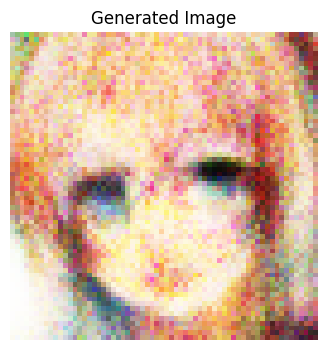

Image saved to generated_image.png


In [27]:
import torch
import matplotlib.pyplot as plt

def generate_and_save_image(generator, latent_dim, output_path='generated_image.png'):
    generator.eval()  # Set to eval mode

    device = next(generator.parameters()).device
    z = torch.randn(1, latent_dim).to(device)

    with torch.no_grad():
        generated_image = generator(z)

    # Reshape and convert image to numpy
    img = generated_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = (img + 1) / 2  # Normalize to [0, 1] for visualization

    # Clip to avoid weird values
    img = img.clip(0, 1)

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Generated Image")
    plt.savefig(output_path)
    plt.show()

    print(f"Image saved to {output_path}")

# Example usage (make sure `generator` is trained or at least defined):
generate_and_save_image(generator, LATENT_DIM, 'generated_image.png')


In [28]:
torch.save(generator.state_dict(), 'finalanimegenerator.pth')
print("Generator model saved as finalanimegenerator.pth")

Generator model saved as finalanimegenerator.pth


In [29]:
# Reinitialize the model with the same architecture and latent dimension
generator = Generator(LATENT_DIM)
generator.load_state_dict(torch.load('finalanimegenerator.pth'))
generator.eval()

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=12288, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

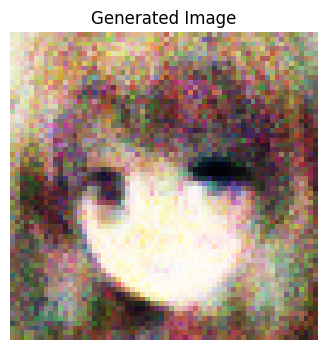

Image saved to generated_image.png


In [33]:
import torch
import matplotlib.pyplot as plt

def generate_and_save_image(generator, latent_dim, output_path='generated_image.png'):
    generator.eval()  # Set to eval mode

    device = next(generator.parameters()).device
    z = torch.randn(1, latent_dim).to(device)

    with torch.no_grad():
        generated_image = generator(z)

    # Reshape and convert image to numpy
    img = generated_image.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    img = (img + 1) / 2  # Normalize to [0, 1] for visualization

    # Clip to avoid weird values
    img = img.clip(0, 1)

    # Plot
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Generated Image")
    plt.savefig(output_path)
    plt.show()

    print(f"Image saved to {output_path}")

# Example usage (make sure `generator` is trained or at least defined):
generate_and_save_image(generator, LATENT_DIM, 'generated_image.png')